**Importing Modules**

In [190]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm
import nltk
import sklearn

In [2]:
seed = 1306

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

**Loading the Dataset**

In [24]:
features = datasets.Features({
    "text": datasets.Value("string"),
    "label": datasets.ClassLabel(names=["neg", "pos"])
})

ds = datasets.load_dataset(
    "csv",
    data_files={
        "train": "hf://datasets/ImranzamanML/Arabic-Sentiments/train.tsv",
        "test":  "hf://datasets/ImranzamanML/Arabic-Sentiments/test.tsv",
    },
    delimiter="\t",
    column_names=["label", "text"],
    features=features,
    encoding="utf-8",
)

In [25]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 28326
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 28536
    })
})

In [119]:
from datasets import concatenate_datasets

full_dataset = concatenate_datasets([ds["train"], ds["test"]])

train_val_test = full_dataset.train_test_split(test_size=0.2, seed=42)

val_test = train_val_test["test"].train_test_split(test_size=0.5, seed=42)

ds = {
    "train": train_val_test["train"],
    "validation": val_test["train"],
    "test": val_test["test"],
}

In [125]:
ds

{'train': Dataset({
     features: ['text', 'label'],
     num_rows: 45489
 }),
 'validation': Dataset({
     features: ['text', 'label'],
     num_rows: 5686
 }),
 'test': Dataset({
     features: ['text', 'label'],
     num_rows: 5687
 })}

In [122]:
ds['train'][0]

{'text': 'مازالت معاناة اهالي #ام_الساهك مستمرة و الدرباوية مستمرين في ازعاج وترهيب السكان وسط غياب الجهات المعنية .. والمرفق…',
 'label': 0}

In [123]:
ds['train'].features

{'text': Value('string'), 'label': ClassLabel(names=['neg', 'pos'])}

In [124]:
from datasets import Features, Value, ClassLabel, Sequence

target_features = Features({
    "text": Value("string"),
    "label": ClassLabel(names=["neg", "pos"]),
    "tokens": Sequence(Value("string"))  # length=-1 par défaut (variable)
})

**Tokenization**

In [23]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [29]:
text = 'رحمه الله رحمه واسعه واسكنه فسيح جناته !!!'
print(nltk.word_tokenize(text))

['رحمه', 'الله', 'رحمه', 'واسعه', 'واسكنه', 'فسيح', 'جناته', '!', '!', '!']


In [30]:
def tokenize(example, tokenizer, max_length):
    tokens = tokenizer(example["text"])[:max_length]
    return {"tokens": tokens}

In [126]:
max_length = 256

train_data = ds['train'].map(
    tokenize, fn_kwargs={"tokenizer": nltk.word_tokenize, "max_length": max_length}, features=target_features
)
valid_data = ds['validation'].map(
    tokenize, fn_kwargs={"tokenizer": nltk.word_tokenize, "max_length": max_length}, features=target_features
)
test_data = ds['test'].map(
    tokenize, fn_kwargs={"tokenizer": nltk.word_tokenize, "max_length": max_length}, features=target_features
)

Map:   0%|          | 0/45489 [00:00<?, ? examples/s]

Map:   0%|          | 0/5686 [00:00<?, ? examples/s]

Map:   0%|          | 0/5687 [00:00<?, ? examples/s]

In [127]:
train_data[3536]

{'text': '#عبدالفتاح الإخونج، كيف الحال؟ 😂',
 'label': 1,
 'tokens': ['#', 'عبدالفتاح', 'الإخونج،', 'كيف', 'الحال؟', '😂']}

In [128]:
train_data

Dataset({
    features: ['text', 'label', 'tokens'],
    num_rows: 45489
})

In [129]:
train_data.features

{'text': Value('string'),
 'label': ClassLabel(names=['neg', 'pos']),
 'tokens': List(Value('string'))}

In [130]:
valid_data[0]["tokens"][:25]

['انزين', 'عادي', 'انا', 'احب', 'الدراسه', '😢']

In [131]:
len(train_data), len(valid_data), len(test_data)

(45489, 5686, 5687)

**Creating a Vocabulary**

In [132]:
from collections import Counter

counter = Counter(token for tokens in train_data["tokens"] for token in tokens)
special_tokens = ["<unk>", "<pad>"]
stoi = {tok: i for i, tok in enumerate(special_tokens + [t for t, c in counter.items() if c >= 5])}
itos = {i: tok for tok, i in stoi.items()}

In [133]:
len(itos)

14772

In [134]:
unk_index = stoi["<unk>"]
pad_index = stoi["<pad>"]

In [135]:
# For the tokens that doesn't exist in stoi we should return unk_index
from collections import defaultdict
stoi = defaultdict(lambda: unk_index, stoi)

In [136]:
def lookup_indices(tokens):
    return [stoi[token] for token in tokens]

In [137]:
def lookup_tokens(ids):
    return [itos[Id] for Id in ids]

In [138]:
lookup_indices(['رحمه', 'الله', 'رحمه', 'واسعه', 'واسكنه', 'فسيح', 'جناته', '😢'])

[3296, 113, 3296, 0, 6254, 2741, 2742, 135]

**Numericalizing Data**

In [139]:
def numericalize_example(example):
    ids = lookup_indices(example["tokens"])
    return {"ids": ids}

In [140]:
train_data = train_data.map(numericalize_example)
valid_data = valid_data.map(numericalize_example)
test_data = test_data.map(numericalize_example)

Map:   0%|          | 0/45489 [00:00<?, ? examples/s]

Map:   0%|          | 0/5686 [00:00<?, ? examples/s]

Map:   0%|          | 0/5687 [00:00<?, ? examples/s]

In [141]:
test_data[0]

{'text': 'صوره من حدث تجمع ستار وأرز ، وكأنها صورة نيثن دريك من انشارتد 😅 #Uncharted #StarWarsCelebration',
 'label': 1,
 'tokens': ['صوره',
  'من',
  'حدث',
  'تجمع',
  'ستار',
  'وأرز',
  '،',
  'وكأنها',
  'صورة',
  'نيثن',
  'دريك',
  'من',
  'انشارتد',
  '😅',
  '#',
  'Uncharted',
  '#',
  'StarWarsCelebration'],
 'ids': [5297,
  34,
  11174,
  3405,
  0,
  0,
  421,
  3678,
  212,
  0,
  0,
  34,
  0,
  3810,
  5,
  0,
  5,
  0]}

In [149]:
train_data[24]['text']

'من النهارده مدة اي تويته عندي مش هتتعدي ساعتين و هحذفها 😎 لو مهتم فعل التنبيهات ليصلك كل جديد😉'

In [150]:
train_data[24]["tokens"][:20]

['من',
 'النهارده',
 'مدة',
 'اي',
 'تويته',
 'عندي',
 'مش',
 'هتتعدي',
 'ساعتين',
 'و',
 'هحذفها',
 '😎',
 'لو',
 'مهتم',
 'فعل',
 'التنبيهات',
 'ليصلك',
 'كل',
 'جديد😉']

In [151]:
lookup_indices(train_data[24]["tokens"][:20])

[34,
 266,
 267,
 268,
 269,
 270,
 125,
 0,
 271,
 8,
 0,
 272,
 85,
 273,
 274,
 275,
 0,
 38,
 0]

In [152]:
lookup_tokens(train_data[24]["ids"][:20])

['من',
 'النهارده',
 'مدة',
 'اي',
 'تويته',
 'عندي',
 'مش',
 '<unk>',
 'ساعتين',
 'و',
 '<unk>',
 '😎',
 'لو',
 'مهتم',
 'فعل',
 'التنبيهات',
 '<unk>',
 'كل',
 '<unk>']

In [153]:
train_data = train_data.with_format(type="torch", columns=["ids", "label"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label"])
test_data = test_data.with_format(type="torch", columns=["ids", "label"])

In [155]:
train_data[24]["label"]

tensor(1)

In [156]:
train_data[24]["ids"][:10]

tensor([ 34, 266, 267, 268, 269, 270, 125,   0, 271,   8])

In [157]:
train_data[24]

{'label': tensor(1),
 'ids': tensor([ 34, 266, 267, 268, 269, 270, 125,   0, 271,   8,   0, 272,  85, 273,
         274, 275,   0,  38,   0])}

In [160]:
lookup_tokens(train_data[0]["ids"][:30].tolist())

['مازالت',
 'معاناة',
 'اهالي',
 '#',
 'ام_الساهك',
 'مستمرة',
 'و',
 'الدرباوية',
 'مستمرين',
 'في',
 'ازعاج',
 'وترهيب',
 'السكان',
 'وسط',
 'غياب',
 'الجهات',
 'المعنية',
 '..',
 'والمرفق…']

**Creating Data Loaders**

In [161]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "label": batch_label}
        return batch

    return collate_fn

In [162]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [164]:
batch_size = 512

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [165]:
next(iter(train_data_loader))

{'ids': tensor([[ 698, 6258,  849,  ...,    1,    1,    1],
         [3046,   55, 3047,  ...,    1,    1,    1],
         [ 717,  893, 3138,  ..., 1095,    1,    1],
         ...,
         [ 383, 1614, 1615,  ...,    1,    1,    1],
         [ 116,    0, 2572,  ...,    1,    1,    1],
         [6355, 3867,    0,  ...,    1,    1,    1]]),
 'label': tensor([1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
         1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
         1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
         0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
         0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
         0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
         1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
         1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
  

**Building the Model**

In [166]:
class NBoW(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, ids):
        # ids = [batch size, seq len]
        embedded = self.embedding(ids)
        # embedded = [batch size, seq len, embedding dim]
        pooled = embedded.mean(dim=1)
        # pooled = [batch size, embedding dim]
        prediction = self.fc(pooled)
        # prediction = [batch size, output dim]
        return prediction

In [167]:
vocab_size = len(stoi)
embedding_dim = 128
output_dim = len(train_data.unique("label"))

model = NBoW(vocab_size, embedding_dim, output_dim, pad_index)

In [168]:
model

NBoW(
  (embedding): Embedding(89072, 128, padding_idx=1)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [169]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 11,401,474 trainable parameters


In [170]:
optimizer = optim.Adam(model.parameters())

In [171]:
criterion = nn.CrossEntropyLoss()

In [173]:
def train(data_loader, model, criterion, optimizer):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"]
        label = batch["label"]
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [174]:
def evaluate(data_loader, model, criterion):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"]
            label = batch["label"]
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [175]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [177]:
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "nbow.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 18.16it/s]


epoch: 0
train_loss: 0.677, train_acc: 0.654
valid_loss: 0.661, valid_acc: 0.751


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 13.86it/s]


epoch: 1
train_loss: 0.627, train_acc: 0.793
valid_loss: 0.600, valid_acc: 0.801


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 13.00it/s]


epoch: 2
train_loss: 0.541, train_acc: 0.838
valid_loss: 0.529, valid_acc: 0.853


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 14.28it/s]


epoch: 3
train_loss: 0.482, train_acc: 0.881
valid_loss: 0.474, valid_acc: 0.891


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 13.86it/s]


epoch: 4
train_loss: 0.428, train_acc: 0.906
valid_loss: 0.429, valid_acc: 0.912


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 13.07it/s]


epoch: 5
train_loss: 0.366, train_acc: 0.927
valid_loss: 0.391, valid_acc: 0.928


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 12.41it/s]


epoch: 6
train_loss: 0.341, train_acc: 0.939
valid_loss: 0.362, valid_acc: 0.937


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 13.66it/s]


epoch: 7
train_loss: 0.308, train_acc: 0.946
valid_loss: 0.339, valid_acc: 0.941


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 13.28it/s]


epoch: 8
train_loss: 0.286, train_acc: 0.951
valid_loss: 0.319, valid_acc: 0.943


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 12.81it/s]

epoch: 9
train_loss: 0.251, train_acc: 0.956
valid_loss: 0.304, valid_acc: 0.946


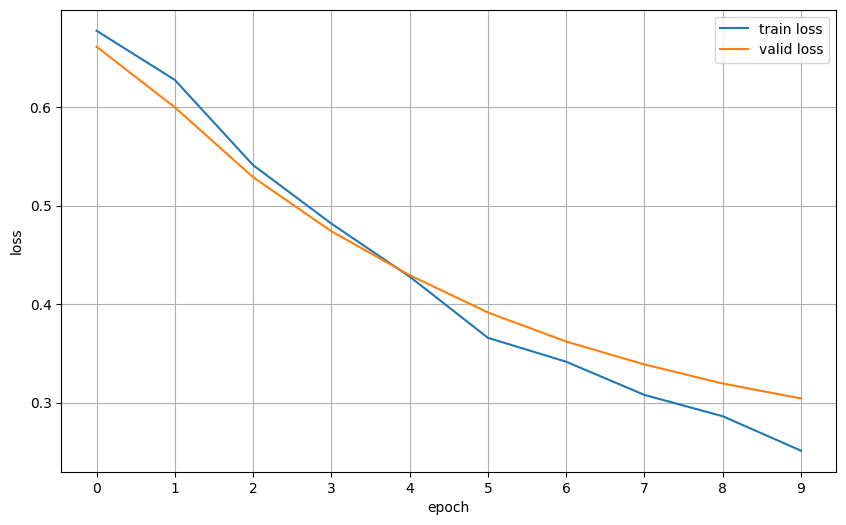

In [178]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

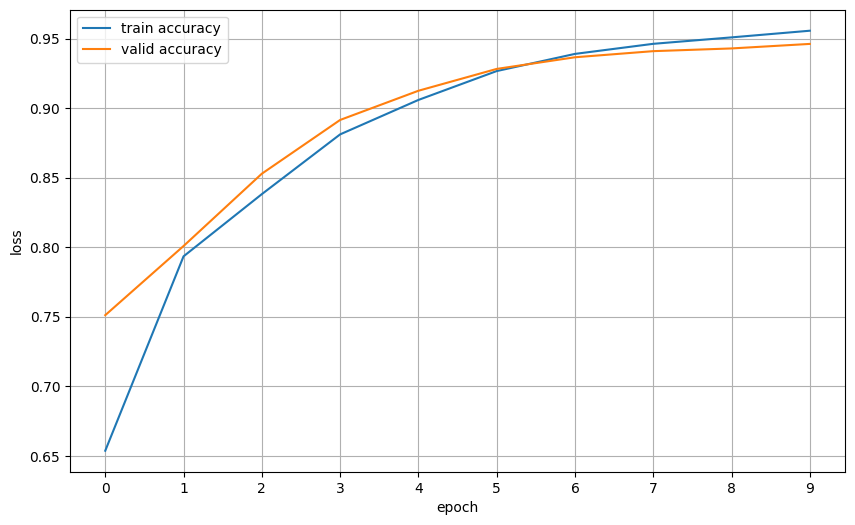

In [179]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [180]:
model.load_state_dict(torch.load("nbow.pt"))

test_loss, test_acc = evaluate(test_data_loader, model, criterion)

evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.36it/s]


In [181]:
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

test_loss: 0.225, test_acc: 0.938


In [191]:
from sklearn.metrics import classification_report

def evaluate_with_report(data_loader, model, criterion):
    model.eval()
    epoch_losses = []
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"]
            labels = batch["label"]
            preds = model(ids)

            # loss
            loss = criterion(preds, labels)
            epoch_losses.append(loss.item())

            # prédictions finales (argmax si classification multi-classes)
            pred_labels = preds.argmax(dim=1).cpu().numpy()
            all_preds.extend(pred_labels)
            all_labels.extend(labels.cpu().numpy())

    avg_loss = np.mean(epoch_losses)
    report = classification_report(all_labels, all_preds, digits=4)
    return avg_loss, report


# Exemple d'utilisation
model.load_state_dict(torch.load("nbow.pt"))

test_loss, test_report = evaluate_with_report(test_data_loader, model, criterion)

print("Test Loss:", test_loss)
print("Classification Report:\n", test_report)

evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 18.29it/s]

Test Loss: 0.2254441144565741
Classification Report:
               precision    recall  f1-score   support

           0     0.9306    0.9366    0.9336      2837
           1     0.9364    0.9305    0.9335      2850

    accuracy                         0.9335      5687
   macro avg     0.9335    0.9335    0.9335      5687
weighted avg     0.9336    0.9335    0.9335      5687



In [183]:
def predict_sentiment(text, model):
    tokens = nltk.word_tokenize(text)
    ids = lookup_indices(tokens)
    tensor = torch.LongTensor(ids).unsqueeze(dim=0)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [188]:
text = "أنا لست بخير"

predict_sentiment(text, model)

(0, 0.999818742275238)

In [197]:
text = "الحمد لله على كل شيء"

predict_sentiment(text, model)

(1, 0.999980092048645)

**Using Embeddings of a model pretrained**

In [198]:
model.embedding.weight

Parameter containing:
tensor([[ 1.8630, -0.3045, -0.8614,  ..., -0.1024, -0.0572,  1.7937],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.6324,  1.1831,  1.4293,  ..., -0.4820,  2.2172,  1.7805],
        ...,
        [-0.1184, -0.5611,  0.6355,  ..., -0.1416, -0.5046,  1.6646],
        [ 0.6114, -2.0983, -0.4004,  ..., -0.1809,  0.6680,  0.7047],
        [-1.1145,  0.5268,  2.2645,  ...,  0.7976,  0.7215,  0.6390]],
       requires_grad=True)

In [199]:
from transformers import AutoTokenizer, AutoModel

pretrained_name = "asafaya/bert-base-arabic"
tokenizer = AutoTokenizer.from_pretrained(pretrained_name)
hf_model = AutoModel.from_pretrained(pretrained_name)

hf_embeddings = hf_model.get_input_embeddings().weight.data  # (vocab_hf, 768)
hf_dim = hf_embeddings.shape[1]


target_dim = 128

projection = nn.Linear(hf_dim, target_dim, bias=False)
with torch.no_grad():
    projected_hf_embeddings = projection(hf_embeddings)  # (vocab_hf, 128)

new_weights = torch.zeros(len(stoi), target_dim)

for word, idx in stoi.items():
    sub_tokens = tokenizer.tokenize(word)
    sub_ids = tokenizer.convert_tokens_to_ids(sub_tokens)

    if len(sub_ids) > 0 and all(i != tokenizer.unk_token_id for i in sub_ids):
        vecs = projected_hf_embeddings[sub_ids]
        new_weights[idx] = vecs.mean(dim=0)
    else:
        new_weights[idx] = torch.randn(target_dim)

embedding_layer = nn.Embedding.from_pretrained(new_weights, freeze=False)

print("Embedding matrix shape:", embedding_layer.weight.shape)

tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

C:\Users\user\miniconda3\envs\data\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub\models--asafaya--bert-base-arabic. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

C:\Users\user\miniconda3\envs\data\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Embedding matrix shape: torch.Size([89072, 128])


In [202]:
vocab_size = len(stoi)
embedding_dim = 128
output_dim = len(train_data.unique("label"))

model = NBoW(vocab_size, embedding_dim, output_dim, pad_index)

In [200]:
embedding_layer.weight

Parameter containing:
tensor([[ 0.0196,  0.0182, -0.0089,  ..., -0.0046,  0.0084,  0.0085],
        [ 0.0195,  0.0300, -0.0205,  ..., -0.0093, -0.0004, -0.0024],
        [ 0.0043,  0.0354, -0.0466,  ..., -0.0124,  0.0010, -0.0119],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       requires_grad=True)

In [203]:
model.embedding.weight.data = embedding_layer.weight

In [204]:
model.embedding.weight

Parameter containing:
tensor([[ 0.0196,  0.0182, -0.0089,  ..., -0.0046,  0.0084,  0.0085],
        [ 0.0195,  0.0300, -0.0205,  ..., -0.0093, -0.0004, -0.0024],
        [ 0.0043,  0.0354, -0.0466,  ..., -0.0124,  0.0010, -0.0119],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       requires_grad=True)

In [205]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [207]:
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "nbow_emb_pretrained.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17.92it/s]


epoch: 0
train_loss: 0.679, train_acc: 0.610
valid_loss: 0.656, valid_acc: 0.764


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 13.73it/s]


epoch: 1
train_loss: 0.597, train_acc: 0.808
valid_loss: 0.566, valid_acc: 0.823


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 12.47it/s]


epoch: 2
train_loss: 0.490, train_acc: 0.877
valid_loss: 0.489, valid_acc: 0.882


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.03it/s]


epoch: 3
train_loss: 0.439, train_acc: 0.909
valid_loss: 0.435, valid_acc: 0.912


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 13.02it/s]


epoch: 4
train_loss: 0.373, train_acc: 0.935
valid_loss: 0.391, valid_acc: 0.927


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 12.23it/s]


epoch: 5
train_loss: 0.326, train_acc: 0.946
valid_loss: 0.358, valid_acc: 0.938


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 13.05it/s]


epoch: 6
train_loss: 0.293, train_acc: 0.953
valid_loss: 0.332, valid_acc: 0.943


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 13.34it/s]


epoch: 7
train_loss: 0.266, train_acc: 0.958
valid_loss: 0.311, valid_acc: 0.945


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 13.12it/s]


epoch: 8
train_loss: 0.241, train_acc: 0.961
valid_loss: 0.295, valid_acc: 0.947


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 12.98it/s]

epoch: 9
train_loss: 0.244, train_acc: 0.964
valid_loss: 0.281, valid_acc: 0.948


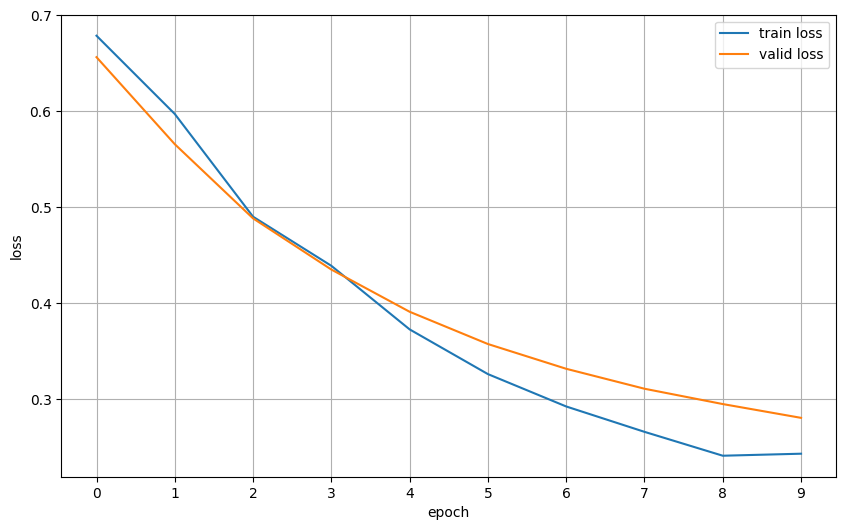

In [208]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

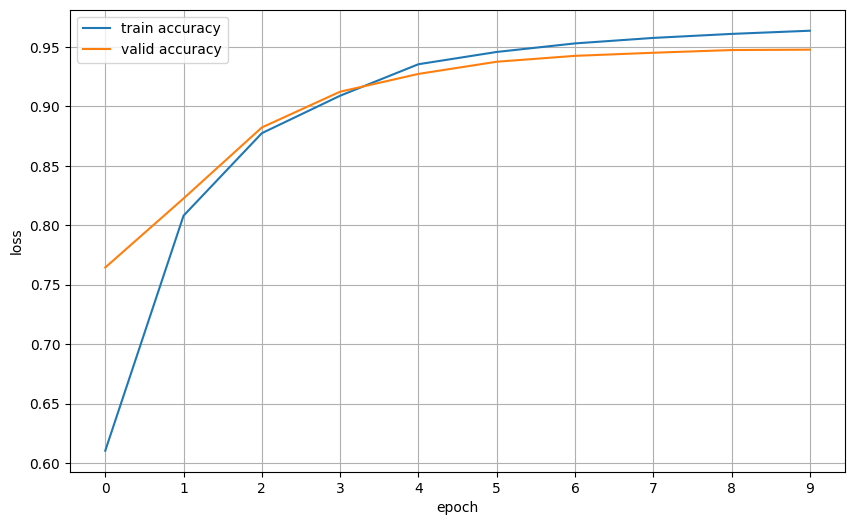

In [209]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [210]:
model.load_state_dict(torch.load("nbow_emb_pretrained.pt"))

test_loss, test_acc = evaluate(test_data_loader, model, criterion)

evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.26it/s]


In [211]:
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

test_loss: 0.207, test_acc: 0.942


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.87it/s]


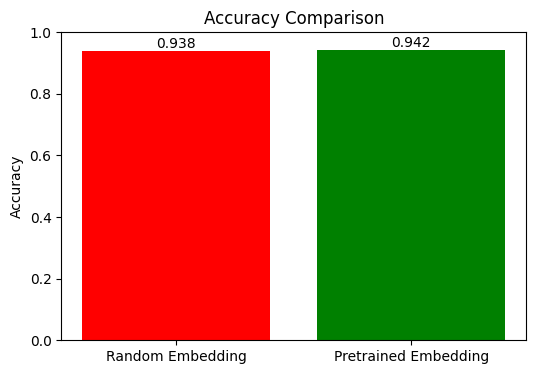

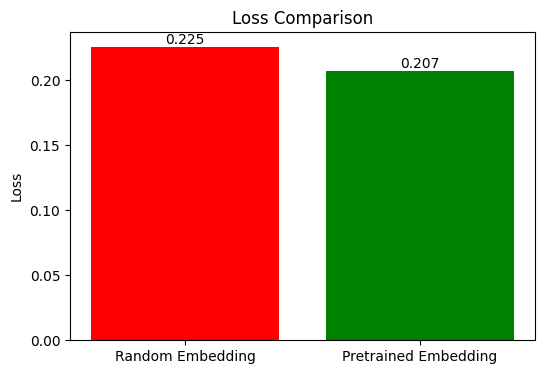

In [214]:
def eval_model(path):
    model.load_state_dict(torch.load(path))
    loss, acc = evaluate(test_data_loader, model, criterion)
    return loss, acc

loss_pretrained, acc_pretrained = eval_model("nbow_emb_pretrained.pt")
loss_random, acc_random = eval_model("nbow_emb.pt")

labels = ["Random Embedding", "Pretrained Embedding"]
losses = [loss_random, loss_pretrained]
accs = [acc_random, acc_pretrained]

# -------------------------------
# Plot Comparaison Accuracy
# -------------------------------
plt.figure(figsize=(6,4))
bars = plt.bar(labels, accs, color=["red", "green"])
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison")
plt.ylim(0, 1)
for bar, val in zip(bars, accs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f"{val:.3f}", ha="center", va="bottom")
plt.show()

# -------------------------------
# Plot Comparaison Loss
# -------------------------------
plt.figure(figsize=(6,4))
bars = plt.bar(labels, losses, color=["red", "green"])
plt.ylabel("Loss")
plt.title("Loss Comparison")
for bar, val in zip(bars, losses):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f"{val:.3f}", ha="center", va="bottom")
plt.show()